# Imports

In [1]:
import pickle
import random
import math
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms.functional as F

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# %cd '/content/drive/My Drive/'
# os.getcwd()

# Load Pickle Files

load the pickle files, audio_data is a list of arrays, where the arrays are of different shapes

In [2]:
def trim_array(arr):
    if np.all(arr == 0):  # Check if the array is all zeros
        return arr
    first_non_zero = np.argmax(arr != 0)
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0)
    return arr[first_non_zero:last_non_zero]

In [3]:
allaudios = [] # Creates an empty list
for root, dirs, files in os.walk("train"):
    i=0 
    for file in files:
        if file.endswith(".pkl"):
           audio = file
           openaudios = open(os.getcwd() + "/train/" + audio, 'rb')
           loadedaudios = pickle.load(openaudios)
           
           allaudios.append(loadedaudios)
           i+=1
           if i==1000:
               break

audio_data = []
valence = []
audio_lengths = []
for audio in allaudios:
    # Get Rid of front and end trailing zeros
    audio_trimmed = trim_array(audio['audio_data'])
    audio_data.append(audio_trimmed)

    audio_length = len(audio_trimmed)
    audio_lengths.append(audio_length)
    valence.append(audio['valence'])

# Data Investigation

In [4]:
print(len(audio_data))
print(len(valence))

1000
1000


In [5]:
mean = np.mean(np.concatenate(audio_data))
mom = np.mean([np.mean(arr) for arr in audio_data]) # mean of means

std = np.std(np.concatenate(audio_data))
average_std = np.mean([np.std(arr) for arr in audio_data])

print(f'Concatenated mean: {mean} \nMean of Means:{mom} \nConcatenated std: {std} \nAverage std per array {average_std}')


Concatenated mean: -1.8226674001198262e-05 
Mean of Means:-1.4511107110593002e-05 
Concatenated std: 0.09245172888040543 
Average std per array 0.07222107797861099


does not max sense to go off max better to take mean or median 

Mean Length: 35832.724
Median Length: 32108.5
Standard Deviation: 20349.094525895347
Minimum Length: 8160
Maximum Length: 149856


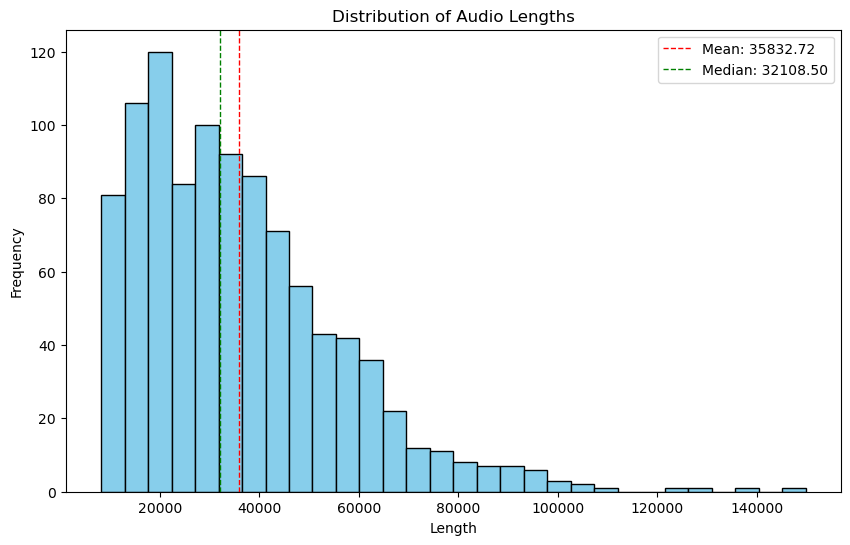

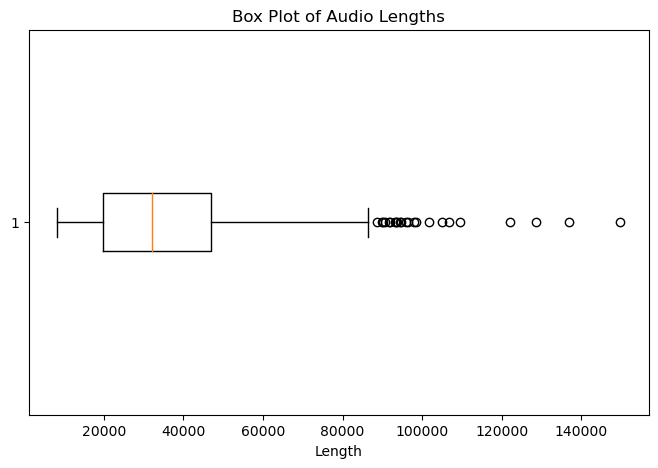

In [6]:
mean_length = np.mean(audio_lengths)
median_length = np.median(audio_lengths)
std_dev = np.std(audio_lengths)
min_length = np.min(audio_lengths)
max_length = np.max(audio_lengths)

print("Mean Length:", mean_length)
print("Median Length:", median_length)
print("Standard Deviation:", std_dev)
print("Minimum Length:", min_length)
print("Maximum Length:", max_length)

# Histogram of the lengths
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.legend()
plt.show()

# Optional: Box Plot
plt.figure(figsize=(8, 5))
plt.boxplot(audio_lengths, vert=False)
plt.title('Box Plot of Audio Lengths')
plt.xlabel('Length')
plt.show()

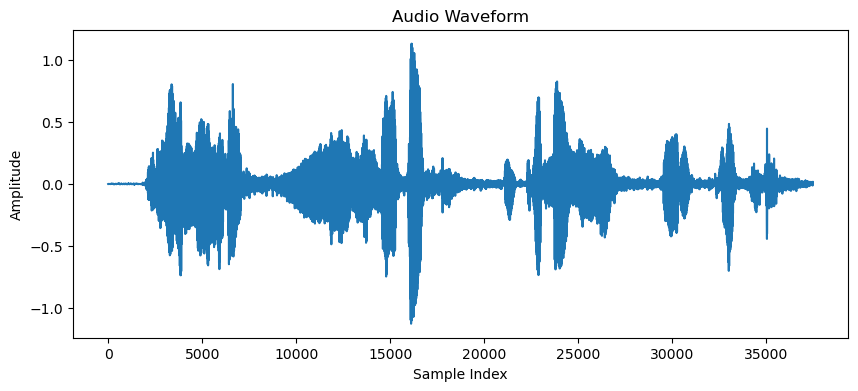

In [7]:
plt.figure(figsize=(10, 4))  # Specify the figure size
plt.plot(audio_data[10])    # Plot the audio data
plt.title('Audio Waveform')  # Set the title of the plot
plt.xlabel('Sample Index')   # Label for the x-axis
plt.ylabel('Amplitude')      # Label for the y-axis
plt.show()  

# Pad Trunc

https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

In [8]:
def pad_trunc_audio(audio_data, target_length = int(np.percentile(audio_lengths, 95))):
    standardized_data = []
    for data in audio_data:
        if len(data) < target_length:
            padded_data = np.pad(data, (0, target_length - len(data)), 'constant', constant_values=(0, 0))
            standardized_data.append(padded_data)
        elif len(data) > target_length:
            truncated_data = data[:target_length]
            standardized_data.append(truncated_data)
        else:
            standardized_data.append(data)
    return standardized_data

standardized_audios = pad_trunc_audio(audio_data)


# Train Test Data for Model

In [9]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
size_train = int(round(len(standardized_audios) * 0.8))
X_train = standardized_audios[:size_train]
X_test = standardized_audios[size_train:]
y_train = valence[:size_train]
y_test = valence[size_train:]

batch_size = 64

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.



# Model Setup

## Architecture

In [11]:
class CNN1d(nn.Module):
    def __init__(self, pre_proocesses, hidden_sizes, activation_function):

        super(CNN1d, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function

        self.width = 128

        self.layers = nn.ModuleList()

        # # add preprocessing steps
        # for process in pre_proocesses:
        #     self.layers.append(process)

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv1d(1 if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3))
            self.layers.append(nn.BatchNorm1d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool1d(kernel_size=3))
            self.layers.append(self.activation_function())


        self.layers.append(nn.AdaptiveAvgPool1d(1))
        self.layers.append(nn.Flatten()) 
        self.layers.append(nn.Linear(in_features=self.hidden_sizes[-1], out_features=self.width))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.width, out_features=1))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

Last Year Architecture

In [12]:
# # Create the model

# # increased depth of the network
# n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
# classifier_width = 128
# cnn_layers = []
# output_size = 1

# for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
#     cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
#     cnn_layers.append(nn.ReLU())
#     cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# # adaptive average pooling to obtain features
# cnn_layers.append(nn.AdaptiveAvgPool1d(1))
# cnn_layers.append(nn.Flatten())
# model = nn.Sequential(
#     *cnn_layers,
#     nn.Linear(n_filters[-1], classifier_width),
#     nn.ReLU(),
#     nn.Linear(classifier_width, classifier_width),
#     nn.ReLU(),
#     nn.Linear(classifier_width, output_size),
# )
# # No soft max as loss function expects logits

# model = model.to(device)
# print(model)

## Learning/Valdiation Loop

In [13]:
def calculate_metrics(actual, predicted):

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R^2)": r2
    }


In [14]:
def loss_plot(train_loss, validation_loss):
    epochs = range(1, len(train_loss) + 1) # start at 1 instead of 0
    # Plotting the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [15]:
def train_model(net, optimizer, train_loader, val_loader, epochs):
    # Define the loss function
    criterion = nn.MSELoss()
    # Define the optimizer

    train_loss_lst = []
    val_loss_lst = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        # Iterate over training batches
        for audio, valence in train_loader:
            optimizer.zero_grad()  # Reset gradients
            valence = valence.float() # was double 

            audio = audio.unsqueeze(1) # [batch, channel=1, 128,145]
            audio, valence = audio.to(device), valence.to(device)

            outputs = net(audio)
            outputs = outputs.squeeze()  # Reshape the output to match target
            loss = criterion(outputs, valence)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        net.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for audio, valence in val_loader:
                valence = valence.float() # was double

                audio = audio.unsqueeze(1) # [batch, channel=1, 128,145]
                audio, valence = audio.to(device), valence.to(device)
                outputs = net(audio)
                outputs = outputs.squeeze()  # Reshape the output to match target
                val_loss = criterion(outputs, valence)
                val_running_loss += val_loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_loss_lst.append(val_loss)

        # print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    # #display loss graph
    # loss_plot(train_loss_lst, val_loss_lst)
    # print("Training for CNN is finished.")

    return train_loss_lst, val_loss_lst

## Run Training

In [ ]:
model_self = CNN1d([], [16, 32, 64, 128, 256], nn.ReLU).to(device)
print(model_self)

optimizer = optim.Adam(model_self.parameters(), lr=0.001)
train_loss_lst, val_loss_lst = train_model(model_self, optimizer, train_dataloader, test_dataloader, 10)
loss_plot(train_loss_lst, val_loss_lst)


In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# val_loss_lst = train_model(model, optimizer, train_dataloader, test_dataloader, 10)

# Grid Search For Hyperparameters

# Optimizer Selection

SGD
	Validation Loss: 0.77069

Adagrad
	Validation Loss: 0.7831

Adam
	Validation Loss: 0.78398



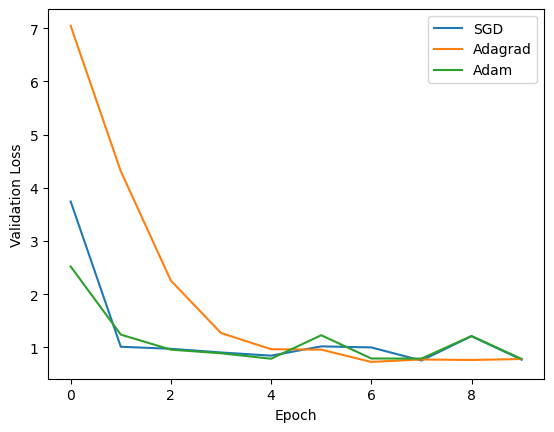

In [16]:
names = [] # Initialize an empty list names to store optimizer names for visualization of results.
learning_rate = 0.001
num_epochs = 10


for opt in [optim.SGD, optim.Adagrad, optim.Adam]:
    names.append(opt.__name__)
    model_1d = CNN1d([], [16, 32, 64, 128, 256], nn.ReLU).to(device)

    if opt is optim.SGD:
        optimizer = opt(model_1d.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    else:
        optimizer = opt(model_1d.parameters(), lr=learning_rate)

    
    train_loss_lst, val_loss_lst = train_model(model_1d, optimizer, train_dataloader, test_dataloader, num_epochs)
    plt.plot(val_loss_lst)
    # Print the validation accuracy and loss in the last epoch
    print(f'{opt.__name__}\n\tValidation Loss: {val_loss_lst[-1]:.5}\n')
    

#Display a legend in the plot for optimizer names.
plt.legend(names)
#Label the x-axis as "Epoch" and the y-axis as "Validation Accuracy."
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
#Show the plot containing the accuracy evolution over epochs for each optimizer.
plt.show()

## Hidden Sizes and Learning Rate

In [17]:
def generate_sequences(start=16, max_value=512):
    sequences = [[start]] 
    finished_sequences = []

    while sequences:
        new_sequences = []
        for seq in sequences:
            last_value = seq[-1]
            
            if seq.count(last_value) < 2:
                new_seq = seq + [last_value]
                new_sequences.append(new_seq)
            
            doubled_value = last_value * 2
            if doubled_value <= max_value:
                new_seq = seq + [doubled_value]
                new_sequences.append(new_seq)
        
        finished_sequences.extend(sequences)
        sequences = new_sequences

    return finished_sequences

In [18]:
def plot_search(results, x_str, y_str, res_str, scale=False):

    # Assuming coarse_results is a list of dictionaries with 'lr', 'hidden_size', 'val_loss', and 'accuracy'
    # Extract relevant information for the heatmap
    lr_values = [result[x_str] for result in results]
    hidden_size_values = [result[y_str] for result in results]
    val_loss_values = [result[res_str] for result in results]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.scatter(lr_values, hidden_size_values, c=val_loss_values, cmap='RdYlGn', marker='o', s=100)
    plt.colorbar(heatmap, label=res_str)
    if scale:
        plt.xscale('log')  # Use a logarithmic scale for learning rates if appropriate

    # Set labels and title
    plt.xlabel(x_str)
    plt.ylabel(y_str)
    plt.title('Hyperparameter Search')
    plt.grid(True)

    # Show the plot
    plt.show()

In [19]:
def hyper_train_setup(hidden_sizes, learning_rate, num_epochs):
  # Create the model
    model_1d = CNN1d([], hidden_sizes, nn.ReLU).to(device)
    optimizer = optim.Adam(model_1d.parameters(), lr=learning_rate)
    # optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    ## Train the model
    train_loss_lst, eval_loss_lst = train_model(model_1d, optimizer, train_dataloader, test_dataloader, num_epochs)
    loss_plot(train_loss_lst, val_loss_lst)
    return eval_loss_lst[-1] # last epoch loss

Epoch 1/10:   0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch, loss=3.5] 


Epoch 1/10, Train Loss: 3.7644, Val Loss: 1.7104


Epoch 2/10: 100%|██████████| 13/13 [00:29<00:00,  2.24s/batch, loss=1.05] 


Epoch 2/10, Train Loss: 1.1352, Val Loss: 0.8839


Epoch 3/10: 100%|██████████| 13/13 [00:32<00:00,  2.48s/batch, loss=0.941]


Epoch 3/10, Train Loss: 1.0133, Val Loss: 0.8719


Epoch 4/10: 100%|██████████| 13/13 [00:33<00:00,  2.56s/batch, loss=0.879]


Epoch 4/10, Train Loss: 0.9471, Val Loss: 1.1640


Epoch 5/10: 100%|██████████| 13/13 [00:40<00:00,  3.10s/batch, loss=0.858]


Epoch 5/10, Train Loss: 0.9243, Val Loss: 1.0872


Epoch 6/10: 100%|██████████| 13/13 [00:38<00:00,  3.00s/batch, loss=0.883]


Epoch 6/10, Train Loss: 0.9511, Val Loss: 2.2819


Epoch 7/10: 100%|██████████| 13/13 [00:41<00:00,  3.23s/batch, loss=0.842]


Epoch 7/10, Train Loss: 0.9068, Val Loss: 1.5961


Epoch 8/10: 100%|██████████| 13/13 [00:38<00:00,  2.99s/batch, loss=0.837]


Epoch 8/10, Train Loss: 0.9014, Val Loss: 1.1539


Epoch 9/10: 100%|██████████| 13/13 [00:42<00:00,  3.29s/batch, loss=0.781]


Epoch 9/10, Train Loss: 0.8411, Val Loss: 0.9475


Epoch 10/10: 100%|██████████| 13/13 [00:40<00:00,  3.10s/batch, loss=0.813]


Epoch 10/10, Train Loss: 0.8760, Val Loss: 1.0415


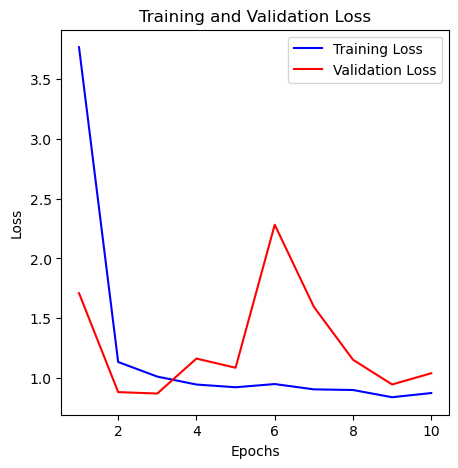

Training for CNN is finished.
1. Learning rate: 0.003954 and hidden sizes: [16, 16, 32]
	Validation loss: 1.0415



Epoch 1/10: 100%|██████████| 13/13 [01:06<00:00,  5.10s/batch, loss=2.28]


Epoch 1/10, Train Loss: 2.4575, Val Loss: 1.3658


Epoch 2/10:  46%|████▌     | 6/13 [00:37<00:43,  6.26s/batch, loss=0.486] 


KeyboardInterrupt: 

In [21]:

# Coarse Random Search
coarse_trials = 7
num_epochs = 10
coarse_results = []

hidden_sizes_list = generate_sequences(16,512)
hidden_options = len(hidden_sizes_list)


for i in range(coarse_trials):
    
    #### COMPLETE THE CODE ####
    lr = 10**random.uniform(math.log10(0.001), math.log10(0.1))
    index = int(2**random.uniform(math.log2(1), math.log2(hidden_options-1)))
    hidden_sizes = hidden_sizes_list[index]
    val_loss = hyper_train_setup(hidden_sizes, lr, num_epochs)

    coarse_results.append({'lr': lr, 'index':index, 'hidden_size': hidden_sizes, 'loss': val_loss})

    print(f"{i+1}. Learning rate: {lr:.4} and hidden sizes: {hidden_sizes}")
    print(f"\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from coarse search
best_coarse_params = min(coarse_results, key=lambda x: x['loss'])
print(f"Best parameters found:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden sizes: {best_coarse_params['hidden_size']}\n - Validation loss: {best_coarse_params['loss']:.5}%")

plot_search(coarse_results, "lr", "index", "loss")

In [ ]:
fine_trials = 5
fine_results = []

for _ in range(fine_trials):
    lr = 2**random.uniform(np.log2(0.5 * best_coarse_params['lr']), np.log2(1.5 * best_coarse_params['lr']))
    index = random.randint(int(0.8 * best_coarse_params['index']), int(1.2 * best_coarse_params['index']) + 1) # not inclusive on the end
    hidden_sizes = hidden_sizes_list[index]
    val_loss = hyper_train_setup(hidden_sizes, lr, num_epochs)

    fine_results.append({'lr': lr, 'index':index, 'hidden_size': hidden_sizes, 'loss': val_loss})

    print(f"Learning rate: {lr:.4} and hidden sizes: {hidden_sizes}")
    print(f"\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from fine search
best_fine_params = min(fine_results, key=lambda x: x['loss'])

print(f"Best parameters found with coarse search:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden sizes: {best_coarse_params['hidden_size']}\n - Validation loss: {best_coarse_params['loss']:.5}%")
print(f"Best parameters found with fine search:\n - Learning rate: {best_fine_params['lr']:.5}\n - Hidden sizes: {best_fine_params['hidden_size']}\n - Validation loss: {best_fine_params['loss']:.5}%")
plot_search(coarse_results + fine_results, "lr", "index", 'loss')

# Last Year

In [ ]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 6

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)